# Importation of the useful librairies

In [1]:
import numpy as np
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.ar_model import AutoReg
from sklearn.decomposition import PCA

# Import the data, downloaded from Yahoo Finance

In [2]:
data_path = "Stocks"
data_dict = {}

for csv_file in os.listdir(data_path):
    stock_path = os.path.join(data_path, csv_file)
    stock_name = re.sub(".csv", "", csv_file)
    dataframe = pd.read_csv(stock_path)
    stock_price = dataframe["Adj Close"].tolist()
    data_dict[stock_name] = stock_price

Here, we keep the *Adj Close* column for each stock since we want the price of the stock adjusted from dividends.
<br>
We store each stock name associated with the list of its evoluting price in the *data_dict* dictionnary. At the period $t_{0}-k\Delta t$, the price of the stock $i$ is $S_{i(t_{0}-k\Delta t)}$, $i$ variates from 1 to $N$, the total number of stocks, and $k$ variates from 1 to $M$, the total amount of periods we consider (one year in this case); $\Delta t$ is the time step, we consider a day in our case (we do not consider the week-ends since we do not have transactions during this period).

# Definiton of a Data class 

In [61]:
class Data():
    
    def __init__(self, start, end, data):
        
        self.start = start
        self.end = end
        self.length_period = end-start
        self.stock_list = data.keys()
        self.data = data
        self.nb_stocks = len(data.keys())
        for stock_name, stock_values in data.items():
            self.data_length = len(stock_values)
            break
        
    def process_analysis(self):
        
        mapping = {}
        inv_mapping = {}
        iteration = 0
        
        for stock in self.stock_list:
            mapping[stock] = iteration
            inv_mapping[iteration] = stock
            iteration += 1
            
        self.mapping = mapping
        self.inv_mapping = inv_mapping
    
        stocks_return_data = {}

        for stock_name, stock_values in self.data.items():
            stock_return_list = []
            for i in range(self.data_length-1):
                stock_return_list.append((stock_values[-(i+1)] - stock_values[-(i+2)])/stock_values[-(i+2)])
            stocks_return_data[stock_name] = stock_return_list
        
        self.stocks_return_data = stocks_return_data
        
        mean_stocks = {}
        var_stocks = {}
        standardized_returns = {}
        
        for stock_name, stock_return in self.stocks_return_data.items():
            stock_return_period = stock_return[self.start:self.end - 1]
            mean = sum(stock_return_period)/self.length_period
            mean_stocks[stock_name] = mean
            var_list = [(elt - mean)**2 for elt in stock_return_period]
            var = sum(var_list)/(self.length_period-1)
            var_stocks[stock_name] = var
            standardized_return_list = [(elt - mean)/(var**(1/2)) for elt in stock_return]   
            standardized_returns[stock_name] = standardized_return_list
            
        self.mean_stocks = mean_stocks
        self.var_stocks = var_stocks
        self.standardized_returns = standardized_returns
            
        correlation_matrix = np.zeros((self.nb_stocks, self.nb_stocks))
        
        for stock_i in self.stock_list:
            for stock_j in self.stock_list:
                correlation_matrix[self.mapping[stock_i], self.mapping[stock_j]] = sum([a * b for a, b in zip(self.standardized_returns[stock_i][self.start:self.end - 1], self.standardized_returns[stock_j][self.start:self.end - 1])])/(len(self.standardized_returns[stock_i]))
        self.correlation_matrix = correlation_matrix
                
        self.eigval, self.eigvect = np.linalg.eigh(self.correlation_matrix)
        
        self.decreasing_eigval = [eigenvalue for eigenvalue in reversed(self.eigval)]
        
        decreasing_eigvect = []
        for i in range(self.nb_stocks):
            decreasing_eigvect.append(self.eigvect[:,-(i+1)])
        
        self.decreasing_eigvect = decreasing_eigvect
        self.perc_var = [(eigval/sum(self.decreasing_eigval))*100 for eigval in self.decreasing_eigval]
        
        eig_var_sum = 0
        iteration = 0
        
        while eig_var_sum < 55:
            eig_var_sum += self.perc_var[iteration]
            iteration += 1
        m = iteration + 1
        
        self.nb_eigval = m
        
        self.useful_eigvect = self.decreasing_eigvect[:self.nb_eigval]
        self.useful_eigval =  self.decreasing_eigval[:self.nb_eigval]
        
        eigenportfolios_returns = []
                  
        for j in range(len(self.useful_eigvect)):
            eigenportfolio_returns = []
            for k in range(self.data_length - 1):
                sum_k = 0
                for i in range(self.nb_stocks):
                    sum_k += (self.useful_eigvect[j][i]/(self.var_stocks[self.inv_mapping[i]]**(1/2)))*self.stocks_return_data[self.inv_mapping[i]][k]
                eigenportfolio_returns.append(sum_k)
            eigenportfolios_returns.append(eigenportfolio_returns)
        
        self.eigenportfolios_returns = eigenportfolios_returns
        
        eigenportfolios = []

        for j in range(len(self.useful_eigvect)):
            eigenportfolio = []
            for i in range(self.nb_stocks):
                eigenportfolio.append(self.useful_eigvect[j][i]/(self.var_stocks[self.inv_mapping[i]]**(1/2)))
            eigenportfolios.append(eigenportfolio)
            
        self.eigenportfolios = eigenportfolios
        
        cumulated_returns = []

        for i in range(self.nb_eigval):
            cumulated_list = [self.eigenportfolios_returns[i][0]]
            for j in range(self.data_length-2):
                cumulated_list.append(cumulated_list[j] + self.eigenportfolios_returns[i][j+1])
            cumulated_returns.append(cumulated_list)
        
        self.cumulated_returns = cumulated_returns
        
        sorted_eigenvectors = []
        sorted_stocks = []

        for j in range(self.nb_eigval):
            sorting = sorted(range(self.nb_stocks), key=lambda k: self.eigenportfolios[j][k])
            sorted_eigenvectors.append([self.eigenportfolios[j][sorting[-(i+1)]] for i in range(self.nb_stocks)])
            sorted_stocks.append([self.inv_mapping[key] for key in reversed(sorting)])
            
        self.sorted_eigenvectors = sorted_eigenvectors
        self.sorted_stocks = sorted_stocks
        
    def normalization_factor(self, reference_data):
        
        normalization_factors = np.linspace(-1/100, 1/100, 10000)
        mse = mean_squared_error(reference_data[self.start:self.end -1], [normalization_factors[0]*elt for elt in self.cumulated_returns[0][self.start:self.end -1]])
        normalization_factor = normalization_factors[0]

        for i in range(len(normalization_factors)-1):
            new_mse = mean_squared_error(reference_data[self.start:self.end -1], [normalization_factors[i+1]*elt for elt in self.cumulated_returns[0][self.start:self.end -1]])
            if new_mse < mse:
                normalization_factor = normalization_factors[i+1]
                mse = new_mse
        
        return normalization_factor
    
    def process_trading_strategy(self, sliding_days, reference_data):
        
        self.sliding_days = sliding_days
        stocks_return_data_chronologically = {}

        for stock_name, stock_values in self.data.items():
            stock_return_list = []
            for i in range(self.data_length-1):
                stock_return_list.append((stock_values[i] - stock_values[i+1])/stock_values[i])
            stocks_return_data_chronologically[stock_name] = stock_return_list
        
        self.stocks_return_data_chronologically = stocks_return_data_chronologically
        
        sliding_days_returns = {}

        for stock_name, stock_returns in self.stocks_return_data_chronologically.items():
            sliding_returns_list = []
            for i in range(self.data_length - 1 - self.sliding_days):
                sliding_returns_list.append(stocks_return_data_chronologically[stock_name][i:i+self.sliding_days])
            sliding_days_returns[stock_name] = sliding_returns_list
            
        self.sliding_days_returns = sliding_days_returns
        
        normalization_factor = self.normalization_factor(reference_data)
        sliding_days_returns_PCA = [0 for i in range(self.data_length -1)]
        investment_factors = {}

        for stock_name, stock_returns in self.stocks_return_data_chronologically.items():
            var = self.var_stocks[stock_name] 
            factor = 0
            for j in range(self.nb_eigval):
                factor += normalization_factor*self.useful_eigvect[j][self.mapping[stock_name]]/var
                for i in range(self.data_length - 1):
                    sliding_days_returns_PCA[i] += normalization_factor*self.useful_eigvect[j][self.mapping[stock_name]]/var * stock_returns[i]
            investment_factors[stock_name] = factor
            
        self.investment_factors = investment_factors            
        self.sliding_days_returns_PCA = sliding_days_returns_PCA
        
        sliding_days_returns_differences = {}

        for stock_name, sliding_returns_list in self.sliding_days_returns.items():
            sliding_returns_differences_list = []
            for i in range(len(sliding_returns_list)):
                sliding_returns_differences_list.append([a - b for a, b in zip(sliding_returns_list[i], self.sliding_days_returns_PCA[i:i+self.sliding_days])])
            sliding_days_returns_differences[stock_name] = sliding_returns_differences_list
            
        self.sliding_days_returns_differences = sliding_days_returns_differences
        
        residuals = {}
        betas = {}
        var_ou_process = {}

        for stock_name, sliding_returns_differences_list in self.sliding_days_returns_differences.items():
            residuals_lists = []
            betas_list = []
            var_ou_list = []
            for elt in sliding_returns_differences_list:
                residuals_list = []
                for i in range(len(elt)):
                    residuals_list.append(sum(elt[0:i+1]))
                beta = residuals_list[-1] / len(elt)
                betas_list.append(beta)
                ou_process = []
                for k in range(len(residuals_list)):
                    ou_process.append(residuals_list[k] - (k+1)*beta)
                residuals_lists.append(ou_process)
                var_ou_list.append(np.var(ou_process))
            betas[stock_name] = betas_list
            residuals[stock_name] = residuals_lists
            var_ou_process[stock_name] = var_ou_list
            
        self.residuals = residuals
        self.betas = betas
        self.var_ou_process = var_ou_process
        
        ou_params = {}

        for stock_name, residuals_lists in self.residuals.items():
            params_list = []
            for residuals_list in residuals_lists:
                model = AutoReg(residuals_list, lags=1)
                model_fit = model.fit()
                params_list.append(model_fit.params)
            ou_params[stock_name] = params_list
            
        self.ou_params = ou_params
        
        validated_stocks_params = {}

        for stock_name, params_list in self.ou_params.items():
            boolean = True
            for params in params_list[self.start:self.end-self.start-self.sliding_days + 1]:
                if params[1] >= 0.9672:
                    boolean = False
            if boolean:
                validated_stocks_params[stock_name] = params_list
                
        self.validated_stocks_params = validated_stocks_params
        
        for stock_name, params_list in self.validated_stocks_params.items():
            for i in range(len(params_list)):
                ki = -np.log(params_list[i][1])*self.data_length
                var = self.var_ou_process[stock_name][i] * 2 * ki
                params_list[i] = np.append(params_list[i], var * (1-np.exp(-2*ki*1/self.data_length))/2*ki)
                
        mean_term_list = [0 for _ in range(self.data_length - self.sliding_days - 1)]

        for stock_name, params_list in self.validated_stocks_params.items():
            for i in range(len(params_list)):
                mean_term_list[i] += params_list[i][0]/(1-params_list[i][1])

        self.mean_term_list = [elt / len(self.validated_stocks_params.keys()) for elt in mean_term_list]
        
        s_scores = {}

        for stock_name, params_list in self.validated_stocks_params.items():
            s_scores_list = []
            for i in range(len(params_list)):
                a = params_list[i][0]
                b = params_list[i][1]
                var_ksi = params_list[i][2]
                s_scores_list.append(((-a*(1-b**2)**(1/2))/((1-b)*var_ksi**(1/2))) + self.mean_term_list[i] * ((1-b**2)/var_ksi)**(1/2))
            s_scores[stock_name] = s_scores_list
            
        self.s_scores = s_scores
        
    def compute_PNL(self, proportion):
        
        maxes = []
        mins = []
        for stock_name, s_score in self.s_scores.items():
            considered_s_scores = s_score[self.end-self.sliding_days:]
            maxes.append(max(considered_s_scores))
            mins.append(min(considered_s_scores))
            
        maxes.sort()
        mins.sort()
        threshold_max = maxes[-round(proportion*len(maxes))]
        threshold_min = mins[round(proportion*len(mins))]

        index_dict = {}
        for stock_name, s_scores in self.s_scores.items():
            considered_s_scores = s_scores[self.end-self.sliding_days:]
            index_dict[stock_name] = [[], [], [], []]
            for i in range(len(considered_s_scores)):
                if considered_s_scores[i] >= threshold_max:
                    index_dict[stock_name][0].append(self.end + 1 + i)
                elif (considered_s_scores[i] >= 0) & (considered_s_scores[i] <= threshold_max*0.4):
                    index_dict[stock_name][1].append(self.end + 1 + i)
                elif (considered_s_scores[i] <= 0) & (considered_s_scores[i] >= threshold_min*0.4):
                    index_dict[stock_name][2].append(self.end + 1 + i)
                elif considered_s_scores[i] <= threshold_min:
                    index_dict[stock_name][3].append(self.end + 1 + i)
                    
        self.index_dict = index_dict

        start_index_dict = {}
        for stock_name, indexes_lists in self.index_dict.items():
            if (len(indexes_lists[0]) == 0) & (len(indexes_lists[-1]) == 0):
                pass
            else:
                start_index_dict[stock_name] = []
                for indexes_list in indexes_lists:
                    tmp = []
                    if len(indexes_list):
                        tmp.append(indexes_list[0])
                    for i in range(len(indexes_list) - 1):
                        if not indexes_list[i+1] == indexes_list[i] + 1:
                            tmp.append(indexes_list[i+1])
                    start_index_dict[stock_name].append(tmp)
        
        self.start_index_dict = start_index_dict

        short_positions_dict = {}
        long_positions_dict = {}

        for stock_name, indexes_lists in self.start_index_dict.items():
            short_positions = []
            long_positions = []
            if len(indexes_lists[0]):
                short_positions.append([indexes_lists[0][0]])
                for i in range(len(indexes_lists[1])):
                    if len(short_positions[-1]) == 1:
                        if indexes_lists[1][i] > short_positions[0][0]:
                            short_positions[0].append(indexes_lists[1][i])
                    else:
                        break
                for i in range(len(indexes_lists[0]) - 1):
                    if len(short_positions[-1]) == 2:
                        if indexes_lists[0][i+1] > short_positions[-1][1]:
                            short_positions.append([indexes_lists[0][i+1]])
                        if len(short_positions[-1]) == 1:
                            for j in range(len(indexes_lists[1])):
                                if indexes_lists[1][j] > short_positions[-1][0]:
                                    short_positions[-1].append(indexes_lists[1][j])
                                    break
                    else:
                        break
            if len(indexes_lists[3]):
                long_positions.append([indexes_lists[3][0]])
                for i in range(len(indexes_lists[2])):
                    if len(long_positions[-1]) == 1:
                        if indexes_lists[2][i] > long_positions[0][0]:
                            long_positions[0].append(indexes_lists[2][i])
                    else:
                        break
                for i in range(len(indexes_lists[3]) - 1):
                    if len(long_positions[-1]) == 2:
                        if indexes_lists[3][i+1] > long_positions[-1][1]:
                            long_positions.append([indexes_lists[3][i+1]])
                        if len(long_positions[-1]) == 1:
                            for j in range(len(indexes_lists[2])):
                                if indexes_lists[2][j] > long_positions[-1][0]:
                                    long_positions[-1].append(indexes_lists[2][j])
                                    break
                    else:
                        break

            long_positions_dict[stock_name] = long_positions
            short_positions_dict[stock_name] = short_positions
        
        self.long_positions_dict = long_positions_dict
        self.short_positions_dict = short_positions_dict
        
        PNL = [0 for _ in range(self.data_length)]
        details = [{} for _ in range(self.data_length)]
        
        market_values = [0 for _ in range(self.data_length)]
        
        for stock_name, values in self.data.items():
            for i in range(len(values)):
                market_values[i] += self.investment_factors[stock_name] * values[i]
                
        self.market_values = market_values
        
        for i in range(len(details)):
            for stock_name in self.stock_list:
                details[i][stock_name] = 0

        for stock_name, short_positions in self.short_positions_dict.items():
            for i in range(len(short_positions)):
                for j in range(len(short_positions[i])):
                    if not j%2:
                        PNL[short_positions[i][j]] -= self.market_values[short_positions[i][j]] - self.data[stock_name][short_positions[i][j]] 
                        details[short_positions[i][j]][stock_name] -= 1
                        for stock, investment_factor in self.investment_factors.items():
                            details[short_positions[i][j]][stock] += investment_factor
                    else:
                        PNL[short_positions[i][j]] += self.market_values[short_positions[i][j]] - self.data[stock_name][short_positions[i][j]] 
                        details[short_positions[i][j]][stock_name] += 1
                        for stock, investment_factor in self.investment_factors.items():
                            details[short_positions[i][j]][stock] -= investment_factor

        for stock_name, long_positions in self.long_positions_dict.items():
            for i in range(len(long_positions)):
                for j in range(len(long_positions[i])):
                    if not j%2:
                        PNL[long_positions[i][j]] += self.market_values[long_positions[i][j]] - self.data[stock_name][long_positions[i][j]] 
                        details[long_positions[i][j]][stock_name] += 1
                        for stock, investment_factor in self.investment_factors.items():
                            details[long_positions[i][j]][stock] -= investment_factor
                    else:
                        PNL[long_positions[i][j]] -= self.market_values[long_positions[i][j]] - self.data[stock_name][long_positions[i][j]] 
                        details[long_positions[i][j]][stock_name] -= 1
                        for stock, investment_factor in self.investment_factors.items():
                            details[long_positions[i][j]][stock] += investment_factor
        
        self.PNL = PNL
        self.cumulated_PNL = [sum(PNL[:(i+1)]) for i in range(len(self.PNL))]
        self.details = details
        
        detailed_portfolios = [{} for _ in range(self.data_length)]
        detailed_portfolios[0] = self.details[0]
        
        for i in range(len(detailed_portfolios) - 1):
            for stock_name, portfolio_value in self.details[i+1].items():
                detailed_portfolios[i+1][stock_name] = detailed_portfolios[i][stock_name] + portfolio_value
        
        self.detailed_portfolios = detailed_portfolios
            

This class will be used to process all the calculus needed to compute the s-score which is the target in order to implement the trading strategy.
In order to initialize a *Data* object, we need some values :
<br>
 - *start* : the start date used to process the correlation matrix and, thus, to process the eigenvalues and eigenvectors
 - *end* : the start date used to process the correlation matrix and, thus, to process the eigenvalues and eigenvectors
 - *data* : dictionnary containing the evolution of the value of the considered stocks
<br>

This class contains three methods :
<br>
 - *process_analysis* : builds all necessary attributes that will be used to extract the eigenvalues and eigenvectors. This method needs nothing in entry.
 - *normalization_factor* : compute the normalization factor in order to put on the right scale the eigenvectors. This method needs in entry a *reference_data* which is in our case the returns of the S&P 500 index.
 - *process_trading_strategy* : builds all necessary attributes that will be used to extract the s-score. This method needs in entry a *reference_data* which is in our case the returns of the S&P 500 index and the *sliding_days* which designates the window used to process the residuals.
<br>

Here are the different attributes that you could find for this class :
<br>
 - *start* : the start date used to process the correlation matrix and, thus, to process the eigenvalues and eigenvectors
 - *end* : the start date used to process the correlation matrix and, thus, to process the eigenvalues and eigenvectors
 - *data* : dictionnary containing the evolution of the value of the considered stocks
 - *length_period* : $end - start$ : length of the considered period
 - *stock_list* : list of the considered stocks
 - *nb_stocks* : number of considered stocks, which is $N$ in the paper
 - *data_length* : length of the entire considered period, which is $M$ in the paper
 - *stocks_return_data* : dictionnary to store each stock name as a key an the associated list of returns as the corresponding value. $\\$
For the $i^{th}$ stock, we have a list of $M$ values : 

\begin{align} 
R_{ik}=\frac{S_{i(t_{1}-(k-1)\Delta t)}-S_{i(t_{1}-k\Delta t)}}{S_{i(t_{1}-k\Delta t)}}, \ k=1,...,M, \ i=1,...,N
\end{align}
 - *mean_stocks* : each stock name is the key and the associated value is the mean of the stock returns : 

\begin{align} 
\bar{R_{i}}=\frac{1}{M}\sum\limits_{k=1}^MR_{ik}, i=1,...,N
\end{align}
<br>

 - *var_stocks* : each stock name is the key and the associated value is the variance of the stock returns : 

\begin{align} 
\bar{\sigma_{i}}=\frac{1}{M-1}\sum\limits_{k=1}^M(R_{ik}-\bar{R_{ik}})^2, i=1,...,N
\end{align}
<br>

 - *standardized_returns* : each stock name is the key and the associated value is the list of the standardized returns, each term of the list defined as follow :

\begin{align} 
Y_{ik}=\frac{R_{ik}-\bar{R_{i}}}{\bar{\sigma_{i}}}, \ k=1,...,M, \ i=1,...,N
\end{align}
 - *mapping* : dictionnary where each key is a stock name and each associated value is a unique indice.
 - *inv_mapping* : the same as the *mapping* dictionnary but the key and the associated value are inverted.
 - *correlation_matrix* : matrix of size ($N$, $N$), each term is defined as follow (the correlation matrix is symmetric and non-negative definite):

\begin{align} 
\rho_{ij}=\frac{1}{M-1}\sum\limits_{k=1}^MY_{ik}Y_{jk}, \ i=1,...,N, \ j=1,...,N
\end{align}
We check that the matrix is symmetric and that each term on the diagonal is equal to 1.
<br>
Indeed, for a given $i$,

\begin{align} 
\rho_{ii}=\frac{1}{M-1}\sum\limits_{k=1}^M(Y_{ik})^2 = \frac{1}{M-1}\frac{\sum\limits_{k=1}^M(R_{ik}-\bar{R_{i}})^2}{\bar{\sigma_{i}}^2}=1
\end{align}
 - *eigval* and *eigvect* : eigenvalues and their associated eigenvectors for the correlation matrix.
 - *decreasing_eigval* : eigenvalues of the correlation matrix ordered in decreasing order.
 - *decreasing_eigvect* : eigenvectors ordered by their corresponding eigenvalues, in decreasing order.
 - *perc_var* : the percentage of the variance explained for each eigenvalue :

\begin{align}
\textit{perc}_{i} = \frac{\lambda_{i}}{\sum\limits_{k=1}^M\lambda_{k}}\times100, \ i=1, ..., N
\end{align}
 - *nb_eigval* : number of eigenvalues used to reach at least 55% of the variance of the correlation matrix, $m$ in the paper.
 - *useful_eigvect* : first eigenvectors, explaining at least 55% of the variance of the correlation matrix.
 - *useful_eigval*: first eigenvalues, explaining at least 55% of the variance of the correlation matrix.
 - *eigenportfolios*, which has one list for each meaningful eigenvector. These lists of size $N$ contain the amounts invested in each of the stocks, for the $j^{th}$ eigenvector, $v^{(j)}=(v_{1}^{(j)},...,v_{N}^{(j)})$, the $i^{th}$ term is calculated as follow :
<br>

\begin{align}
Q_{i}^{(j)}=\frac{v_{i}^{(j)}}{\bar{\sigma_{i}}}, \ i=1,...,N, \ j=1,...,m
\end{align}
<br>


 - *eigenportfolios_returns* which also has one list for each meaningful eigenvector. These lists of size $M$ contain the eigenportfolio returns. For the $j^{th}$ eigenvector, $v^{(j)}=(v_{1}^{(j)},...,v_{N}^{(j)})$, the $k^{th}$ term is calculated as follow :
<br>

\begin{align}
F_{jk}=\sum\limits_{i=1}^N\frac{v_{i}^{(j)}}{\bar{\sigma_{i}}}R_{ik}, \ j=1,...,m, \ k=1,...,M
\end{align}
 - *cumulated_returns* : cumulated returns of the useful eigenportfolios.
 - *sorted_eigenvectors* and *sorted_stocks*: useful eigenvectors but their terms are ordered in decreasing order and the associated stocks.
 - *sliding_days* : window used to process the residuals.
 - *stocks_return_data_chronologically* : dictionnary to store each stock name as a key an the associated list of chonological returns as the corresponding value. $\\$
For the $i^{th}$ stock, we have a list of $M$ values : 

\begin{align} 
R_{ik}=\frac{S_{i(t_{0}+(k-1)\Delta t)}-S_{i(t_{0}+k\Delta t)}}{S_{i(t_{0}+k\Delta t)}}, \ k=1,...,M, \ i=1,...,N
\end{align}

- *sliding_days_returns* : dictionnary where, for each stock, we associate a list (of size $M -$ *sliding_days*). Each term of the list is a list (of size *sliding_days*) representing the evolution of the ordered returns on a *sliding_days*-days sliding period. In other terms the $i^{th}$ term of the list for the $k^{th}$ stock is built as follow :

\begin{align}
[R_{ik}, R_{(i+1)k}, ..., R_{(i+59)k}].
\end{align}

 - *sliding_days_returns_PCA* : dictionnary where, for each stock, we associate a list (of size $M -$ *sliding_days*). Each term of the list is a list (of size *sliding_days) representing the evolution of the ordered PCA returns on a *sliding_days*-days sliding period. In other terms the $i^{th}$ term of the list for the $k^{th}$ stock is built as follow :

\begin{align}
[\sum\limits_{j=1}^m\sum\limits_{k=1}^N\frac{v_{k}^{(j)}}{\bar\sigma_{k}}R_{ik}, \sum\limits_{j=1}^m\sum\limits_{k=1}^N\frac{v_{k}^{(j)}}{\bar\sigma_{k}}R_{(i+1)k}, ..., \sum\limits_{j=1}^m\sum\limits_{k=1}^N\frac{v_{k}^{(j)}}{\bar\sigma_{k}}R_{(i+59)k}],
\end{align}

where $m$ designs the number of selected eigenvectors. In fact, these terms represent the discrete version of $\sum\limits_{j=1}^N\beta_{ij}\frac{dI_{j}(t)}{I_{j}(t)}$ we can find in equation (10) page 14 of the paper.

 - *sliding_days_returns_differences* dictionnary where, for each stock, we associate a list (of size $M -$ *sliding_days*). Each term of the list is a list (of size *sliding_days*) representing the evolution of the difference between the basic ans the PCA ordered returns on a *sliding_days*-days sliding period. In other terms the $i^{th}$ term of the list for the $k^{th}$ stock is built as follow :

\begin{align}
[R_{ik}-\sum\limits_{j=1}^m\sum\limits_{k=1}^N\frac{v_{k}^{(j)}}{\bar\sigma_{k}}R_{ik}, R_{(i+1)k}-\sum\limits_{j=1}^m\sum\limits_{k=1}^N\frac{v_{k}^{(j)}}{\bar\sigma_{k}}R_{(i+1)k}, ..., R_{(i+59)k}-\sum\limits_{j=1}^m\sum\limits_{k=1}^N\frac{v_{k}^{(j)}}{\bar\sigma_{k}}R_{(i+59)k}],
\end{align}

In order to evaluate the s-score of each stock during the entire considerated period, we have to compute the discrete version of the OU process. To do so, we have to calculate the regression between the return of the stock and the corresponding PCA return :

\begin{align}
R_{n}^{S} = \beta_{0}+\beta R_{n}^{I}+\epsilon_{n}, \ n=1, 2, ..., 60
\end{align}

(equation in the appendix of the paper). In our case, we considerate multiple eigenvectors. We can rewrite this equation as : 

\begin{align}
R_{n}^{S} = \beta_{0}+\sum\limits_{j=1}^m\sum\limits_{S}\frac{v_{S}^{(j)}}{\bar\sigma_{S}}R_{n}^{S}+\epsilon_{n}, \ n=1, 2, ..., 60
\end{align}

where $v_{S}^{(j)}$ designs the coordinate of the $j^{th}$ eigenvector, corresponding to the stock $S$.
<br>
Given that we already have a dictionary containing the $R_{n}^{S}-\sum\limits_{j=1}^m\sum\limits_{S}\frac{v_{S}^{(j)}}{\bar\sigma_{S}}R_{n}^{S}, \ n=1, 2, ..., 60$ terms (*sliding_days_returns_differences*), we obtain the corresponding $\beta_{0}+\epsilon_{n}, \ n=1, 2, ..., 60$

Here, we build three new dictionaries :
<br>

 - *residuals* : for each stock, we associate a list of size $M-60$, containing lists of size $60$. The $i^{th}$ term of this kind of lists is defined as follow : 

\begin{align}
X_{i} = \sum\limits_{j=1}^i\epsilon_{j}, \ i=1, 2, ..., 60
\end{align}

which is the discrete version of the OU process. Since we have, for each stock and for each period, $X_{60}=0$, we have that the last term of each list of size $60$ is equal to $\beta_{0}$
<br>

 - *betas* : for each stock, we associate a list of size $M-60$, each term of this list is the $\beta_{0}$ of each period for the targeted stock.
 <br>

 - *var_ou_process* : for each stock, we associate a list of size $M-60$, the $i^{th}$ term of the list is defined as follow : 

\begin{align}
Var([X_{i}, ..., X_{i+59}])
\end{align}

where $m$ designs the number of selected eigenvectors.

Now that we have the discret OU precesses for each stock and for each considerated period, we have to estimate the OU parameters of these processes. To do so, we have to resolve, for each stock and each period, the 1-lag regression model : 
<br>

\begin{align}
X_{n+1}=a+bX_{n}+\zeta_{n+1}, \ n=1, ..., 59
\end{align}

<br>

 - *ou_params* : dictionnary used to store the parameters $a$ and $b$ for each stoch and for each sliding period. This dictionnary is also ised to store another parameter that is useful to compute the s-score : 
\begin{align}
Variance(\zeta)=\sigma^{2}\frac{1-e^{-2\kappa\Delta t}}{2\kappa}
\end{align}
where $\kappa=-log(b)*M$


Since we want, for our trading strategy, stocks with a fast mean-reversion process, we want to have $0 < b < 0.9672$ and we store the parameters of the stocks which respect this inequality.

 - *validated_stocks_params* : dictionary that contains the parameters of the legit stocks.
 - *mean_term_list* : list that contains all the terms $\langle \frac{a}{1-b} \rangle$ for each considerated periods and considering the selected stocks with fast mean reversion, where the brackets are used to design averaging over different stocks.
 - *s_scores* : dictionary containing the s-scores of the stocks with fast mean reversion : 
\begin{align}
s = \frac{-a\sqrt{1-b^{2}}}{(1-b)\sqrt{Variance(\zeta)}} + \langle \frac{a}{1-b} \rangle \sqrt{\frac{1-b^{2}}{Variance(\zeta)}},
\end{align}
 - *index_dict* : For each stock, we associate a list regrouping all the indexes where the s_score of the considered stock is above a certain value or under a certain other value. These values are determined as follow : for the upper bound, we look for the the maximum s_scores for each stock and we take the s_score such that a certain proportion of the maximum s_score are above this selected s_score. We process the same for the lower bound but with the minimum.
 - *start_index_dict* : For each stock, we associate a list regrouping the first index where the s_score of the considered stock is above a certain value or under a certain other value, each time the s_score is above a under these values.
 - *short_positions_dict* : For each stock, we associate the indexes corresponding to the opening and the closing of the short positions.
 - *long_positions_dict* : For each stock, we associate the indexes corresponding to the opening and the closing of the long positions.
 - *PNL* : List containing the profit and loss for the trading strategy and the entire portfolio.
 - *cumulated_PNL* : List containing the cumulated profit and loss for the trading strategy and the entire portfolio.
 - *details* : List containing the details of the trading strategy : the opening and the closing of the different positions, which stock is traded, and how many.

In [62]:
data_0_251 = Data(start=0, end=251, data=data_dict)
data_0_125 = Data(start=0, end=125, data=data_dict)
data_0_60 = Data(start=0, end=60, data=data_dict)
data_100_200 = Data(start=100, end=200, data=data_dict)

In [63]:
data_0_251.process_analysis()
data_0_125.process_analysis()
data_0_60.process_analysis()
data_100_200.process_analysis()

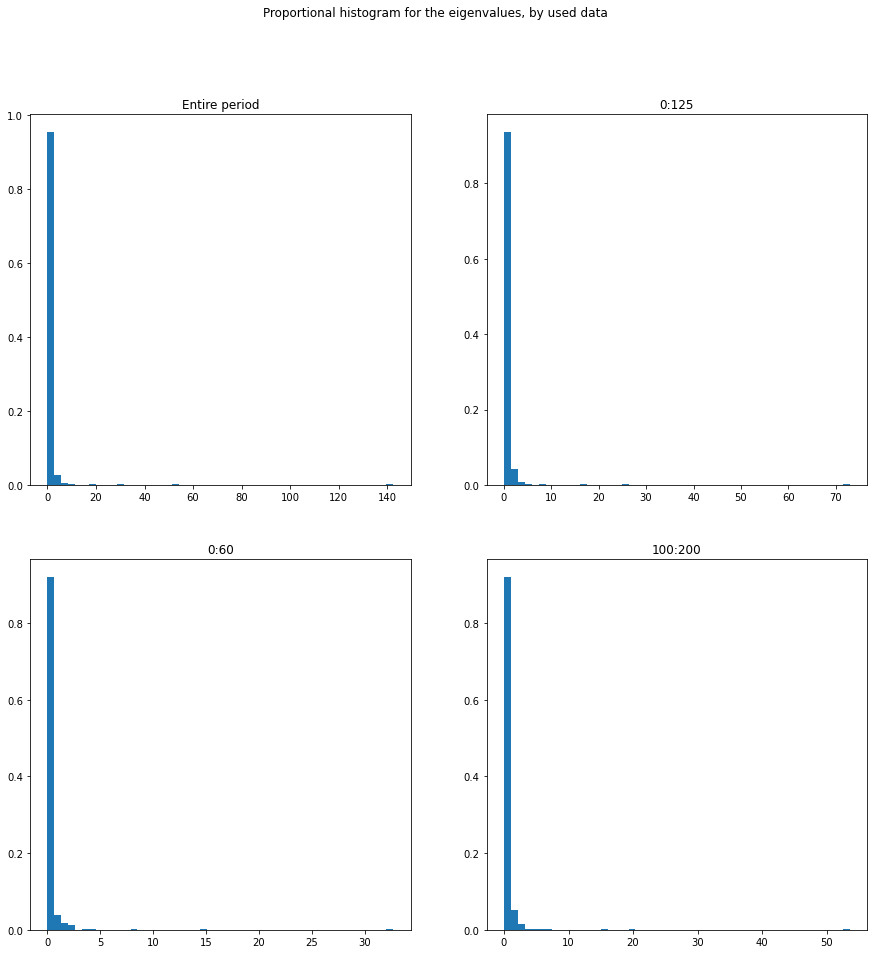

In [6]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Proportional histogram for the eigenvalues, by used data')
n, bins, patches = ax1.hist(data_0_251.decreasing_eigval, weights=np.ones(data_0_251.nb_stocks) / data_0_251.nb_stocks, bins=50)
ax1.set_title("Entire period")
n, bins, patches = ax2.hist(data_0_125.decreasing_eigval, weights=np.ones(data_0_125.nb_stocks) / data_0_125.nb_stocks, bins=50)
ax2.set_title("0:125")
n, bins, patches = ax3.hist(data_0_60.decreasing_eigval, weights=np.ones(data_0_60.nb_stocks) / data_0_60.nb_stocks, bins=50)
ax3.set_title("0:60")
n, bins, patches = ax4.hist(data_100_200.decreasing_eigval, weights=np.ones(data_100_200.nb_stocks) / data_100_200.nb_stocks, bins=50)
ax4.set_title("100:200")
plt.show()

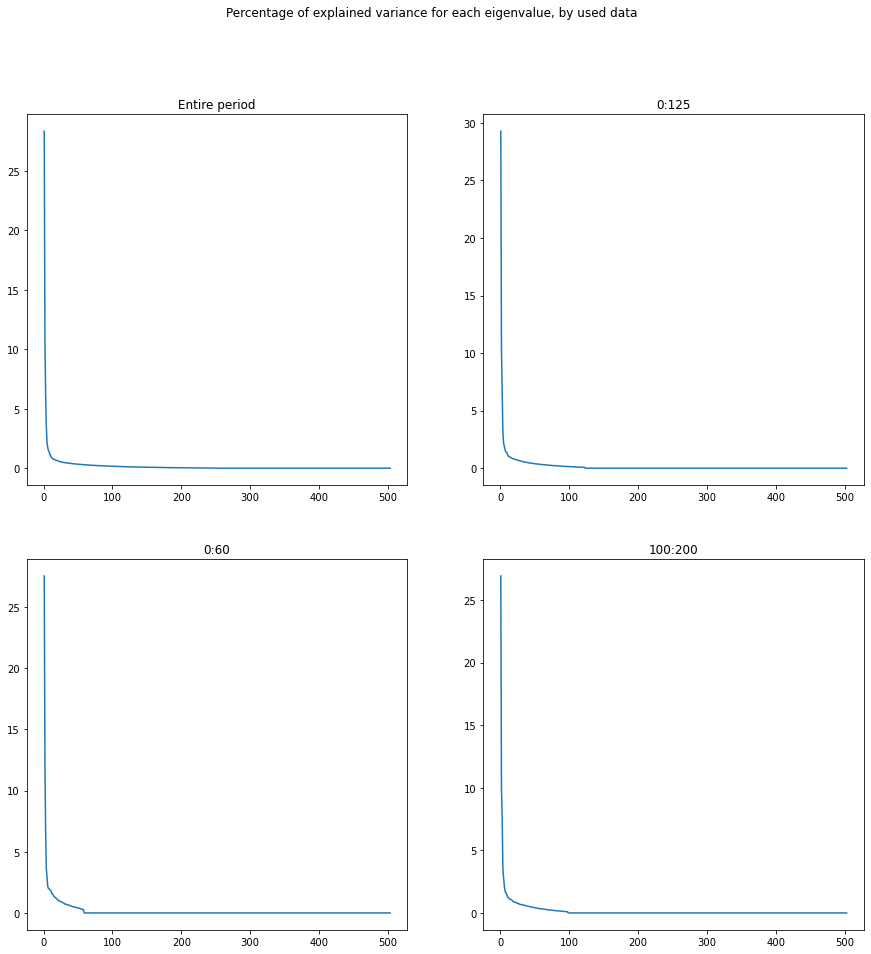

In [7]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Percentage of explained variance for each eigenvalue, by used data')
ax1.set_title("Entire period")
ax1.plot([(i+1) for i in range(data_0_251.nb_stocks)], data_0_251.perc_var)
ax2.set_title("0:125")
ax2.plot([(i+1) for i in range(data_0_125.nb_stocks)], data_0_125.perc_var)
ax3.set_title("0:60")
ax3.plot([(i+1) for i in range(data_0_60.nb_stocks)], data_0_60.perc_var)
ax4.set_title("100:200")
ax4.plot([(i+1) for i in range(data_100_200.nb_stocks)], data_100_200.perc_var)
plt.show()

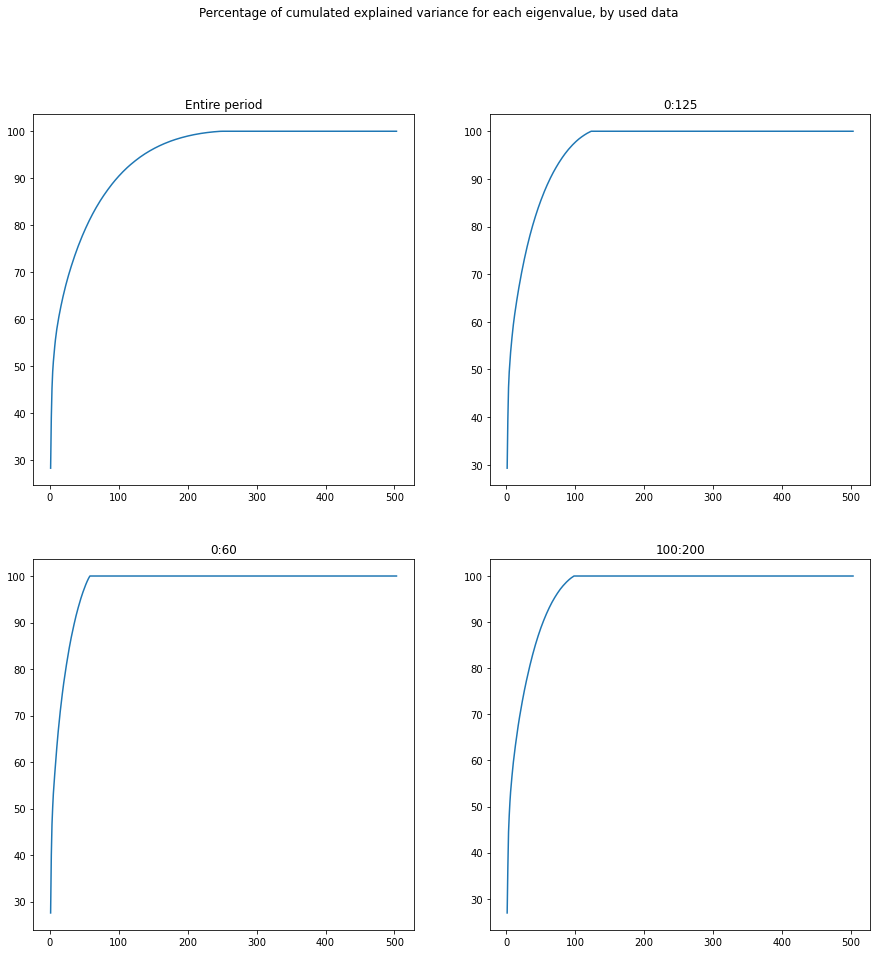

In [8]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Percentage of cumulated explained variance for each eigenvalue, by used data')
ax1.set_title("Entire period")
ax1.plot([(i+1) for i in range(data_0_251.nb_stocks)], [sum(data_0_251.perc_var[0:i+1]) for i in range(len(data_0_251.perc_var))])
ax2.set_title("0:125")
ax2.plot([(i+1) for i in range(data_0_251.nb_stocks)], [sum(data_0_125.perc_var[0:i+1]) for i in range(len(data_0_125.perc_var))])
ax3.set_title("0:60")
ax3.plot([(i+1) for i in range(data_0_251.nb_stocks)], [sum(data_0_60.perc_var[0:i+1]) for i in range(len(data_0_60.perc_var))])
ax4.set_title("100:200")
ax4.plot([(i+1) for i in range(data_0_251.nb_stocks)], [sum(data_100_200.perc_var[0:i+1]) for i in range(len(data_100_200.perc_var))])
plt.show()

In [9]:
SP500_path = "SPX.csv"
SP500_dataframe = pd.read_csv(SP500_path, sep=";", header=None)
SP500_values = pd.to_numeric(SP500_dataframe[5].apply(lambda x: x.replace(',','.'))).to_list()
SP500_returns = [(SP500_values[-(i+1)] - SP500_values[-(i+2)])/SP500_values[-(i+2)] for i in range(len(SP500_values) - 1)]
SP500_cumulated_returns = [sum(SP500_returns[:i]) for i in range(len(SP500_returns))]

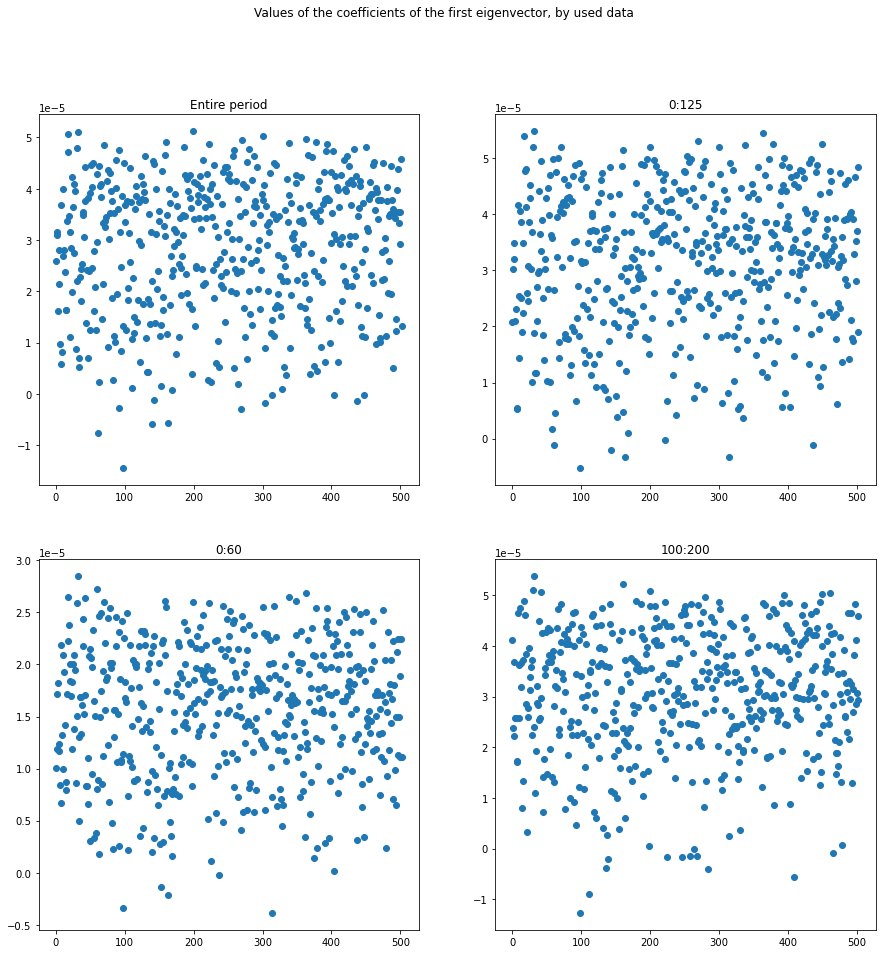

In [10]:
normalization_factor_0_251 = data_0_251.normalization_factor(SP500_cumulated_returns)
normalization_factor_0_125 = data_0_125.normalization_factor(SP500_cumulated_returns)
normalization_factor_0_60 = data_0_60.normalization_factor(SP500_cumulated_returns)
normalization_factor_100_200 = data_100_200.normalization_factor(SP500_cumulated_returns)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Values of the coefficients of the first eigenvector, by used data')
ax1.set_title("Entire period")
ax1.scatter([i for i in range(data_0_251.nb_stocks)], [normalization_factor_0_251 * elt for elt in data_0_251.decreasing_eigvect[0]])
ax2.set_title("0:125")
ax2.scatter([i for i in range(data_0_125.nb_stocks)], [normalization_factor_0_125 * elt for elt in data_0_125.decreasing_eigvect[0]])
ax3.set_title("0:60")
ax3.scatter([i for i in range(data_0_60.nb_stocks)], [normalization_factor_0_60 * elt for elt in data_0_60.decreasing_eigvect[0]])
ax4.set_title("100:200")
ax4.scatter([i for i in range(data_100_200.nb_stocks)], [normalization_factor_100_200 * elt for elt in data_100_200.decreasing_eigvect[0]])
plt.show()

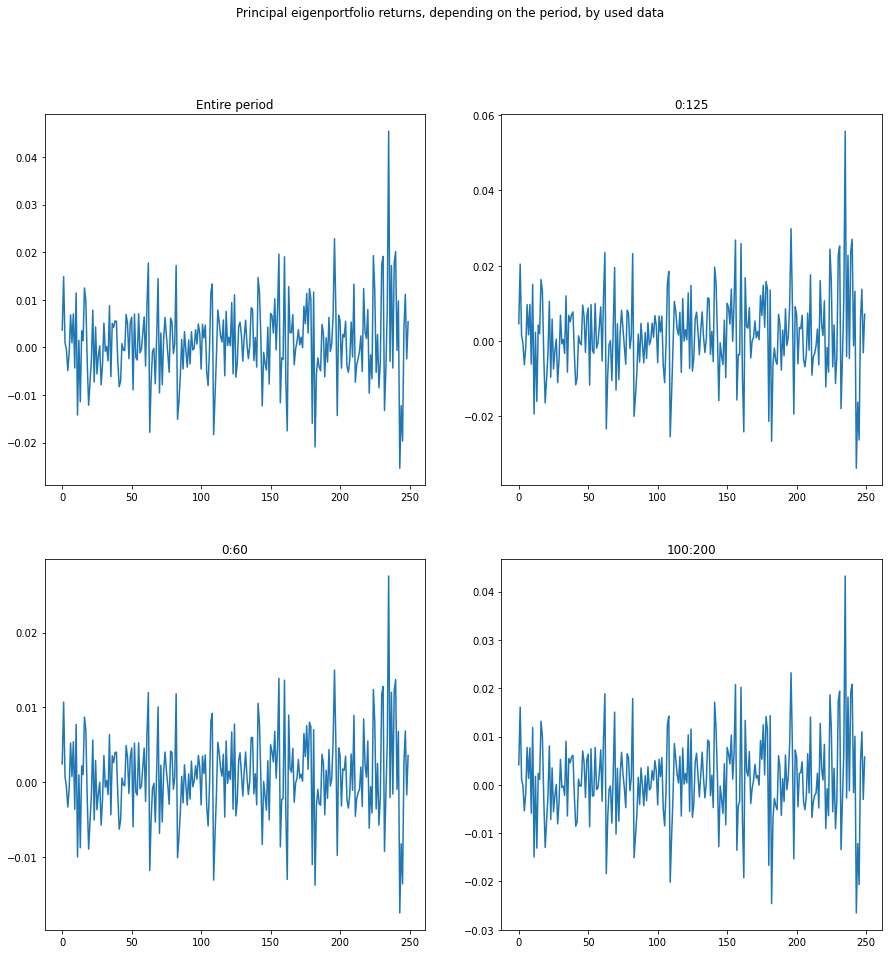

In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Principal eigenportfolio returns, depending on the period, by used data')
ax1.set_title("Entire period")
ax1.plot([i for i in range(data_0_251.data_length - 1)], [normalization_factor_0_251 * elt for elt in data_0_251.eigenportfolios_returns[0]])
ax2.set_title("0:125")
ax2.plot([i for i in range(data_0_125.data_length - 1)], [normalization_factor_0_125 * elt for elt in data_0_125.eigenportfolios_returns[0]])
ax3.set_title("0:60")
ax3.plot([i for i in range(data_0_60.data_length - 1)], [normalization_factor_0_60 * elt for elt in data_0_60.eigenportfolios_returns[0]])
ax4.set_title("100:200")
ax4.plot([i for i in range(data_100_200.data_length - 1)], [normalization_factor_100_200 * elt for elt in data_100_200.eigenportfolios_returns[0]])
plt.show()

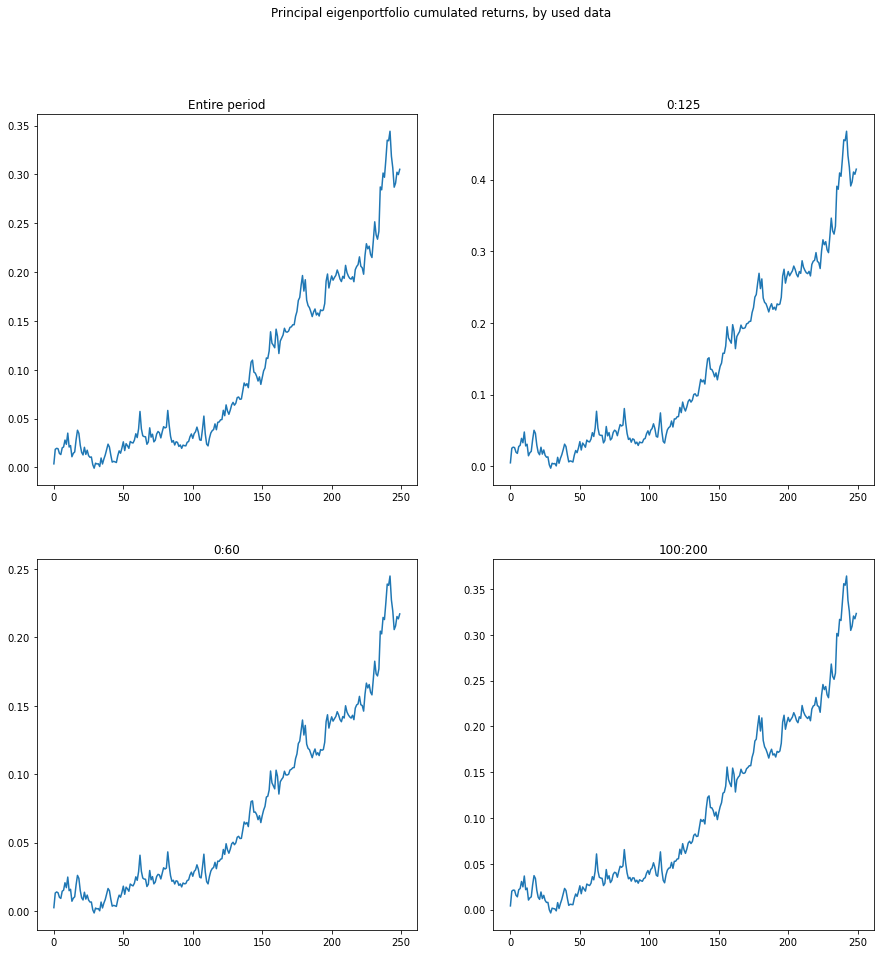

In [12]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Principal eigenportfolio cumulated returns, by used data')
ax1.set_title("Entire period")
ax1.plot([i for i in range(data_0_251.data_length - 1)], [normalization_factor_0_251 * elt for elt in data_0_251.cumulated_returns[0]])
ax2.set_title("0:125")
ax2.plot([i for i in range(data_0_125.data_length - 1)], [normalization_factor_0_125 * elt for elt in data_0_125.cumulated_returns[0]])
ax3.set_title("0:60")
ax3.plot([i for i in range(data_0_60.data_length - 1)], [normalization_factor_0_60 * elt for elt in data_0_60.cumulated_returns[0]])
ax4.set_title("100:200")
ax4.plot([i for i in range(data_100_200.data_length - 1)], [normalization_factor_100_200 * elt for elt in data_100_200.cumulated_returns[0]])
plt.show()

# Evolution of the S&P 500 index

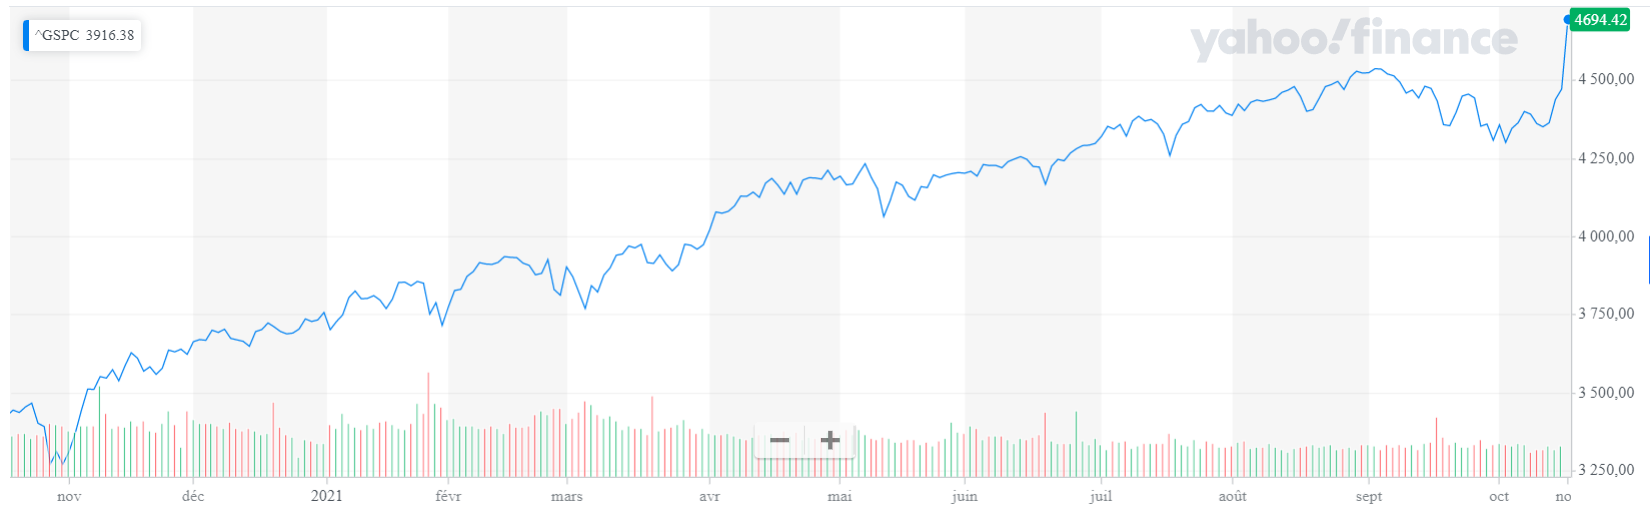


# Check relation between eigenportfolio and the S&P 500 index

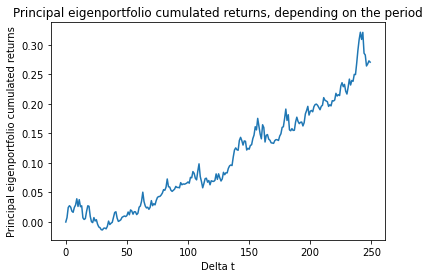

In [13]:
plt.plot([k for k in range(data_0_251.length_period - 1)], SP500_cumulated_returns)
plt.xlabel("Delta t")
plt.ylabel("Principal eigenportfolio cumulated returns")
plt.title("Principal eigenportfolio cumulated returns, depending on the period")
plt.show()

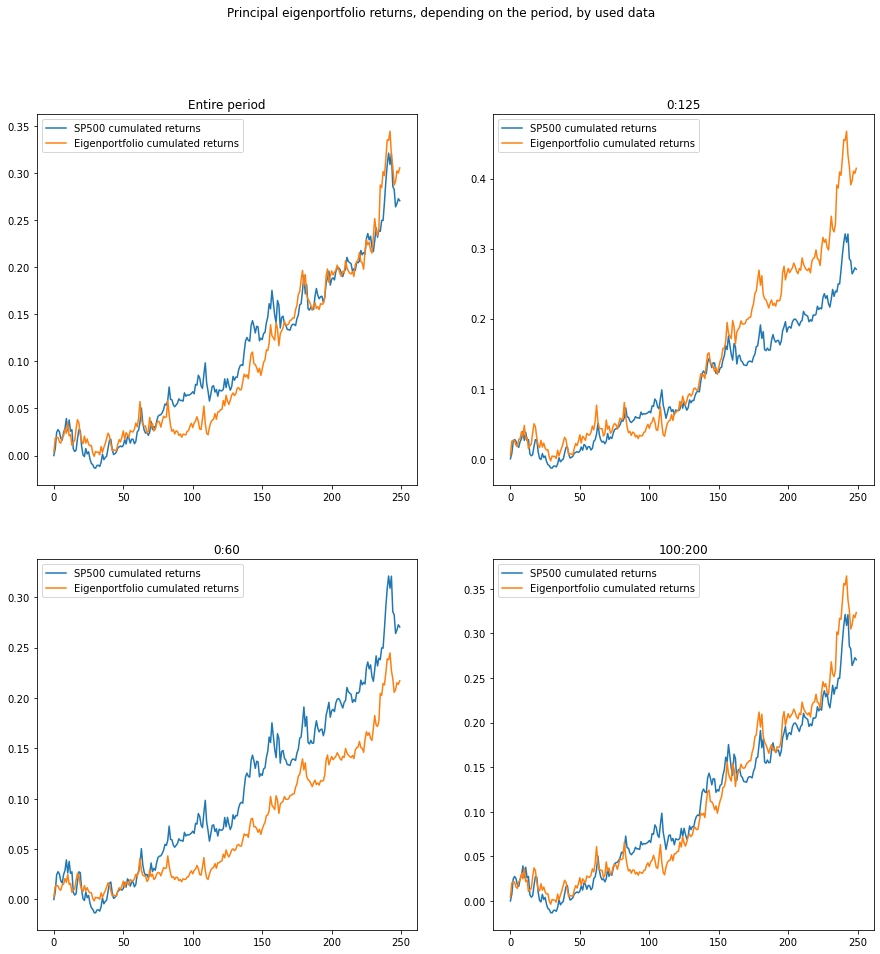

In [14]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Principal eigenportfolio returns, depending on the period, by used data')
ax1.set_title("Entire period")
ax1.plot([i for i in range(data_0_251.data_length - 1)], SP500_cumulated_returns, label="SP500 cumulated returns")
ax1.plot([i for i in range(data_0_251.data_length - 1)], [elt * normalization_factor_0_251 for elt in data_0_251.cumulated_returns[0]], label="Eigenportfolio cumulated returns")
ax1.legend()
ax2.set_title("0:125")
ax2.plot([i for i in range(data_0_125.data_length - 1)], SP500_cumulated_returns, label="SP500 cumulated returns")
ax2.plot([i for i in range(data_0_125.data_length - 1)], [elt * normalization_factor_0_125 for elt in data_0_125.cumulated_returns[0]], label="Eigenportfolio cumulated returns")
ax2.legend()
ax3.set_title("0:60")
ax3.plot([i for i in range(data_0_60.data_length - 1)], SP500_cumulated_returns, label="SP500 cumulated returns")
ax3.plot([i for i in range(data_0_60.data_length - 1)], [elt * normalization_factor_0_60 for elt in data_0_60.cumulated_returns[0]], label="Eigenportfolio cumulated returns")
ax3.legend()
ax4.set_title("100:200")
ax4.plot([i for i in range(data_100_200.data_length - 1)], SP500_cumulated_returns, label="SP500 cumulated returns")
ax4.plot([i for i in range(data_100_200.data_length - 1)], [elt * normalization_factor_100_200 for elt in data_100_200.cumulated_returns[0]], label="Eigenportfolio cumulated returns")
ax4.legend()
plt.show()

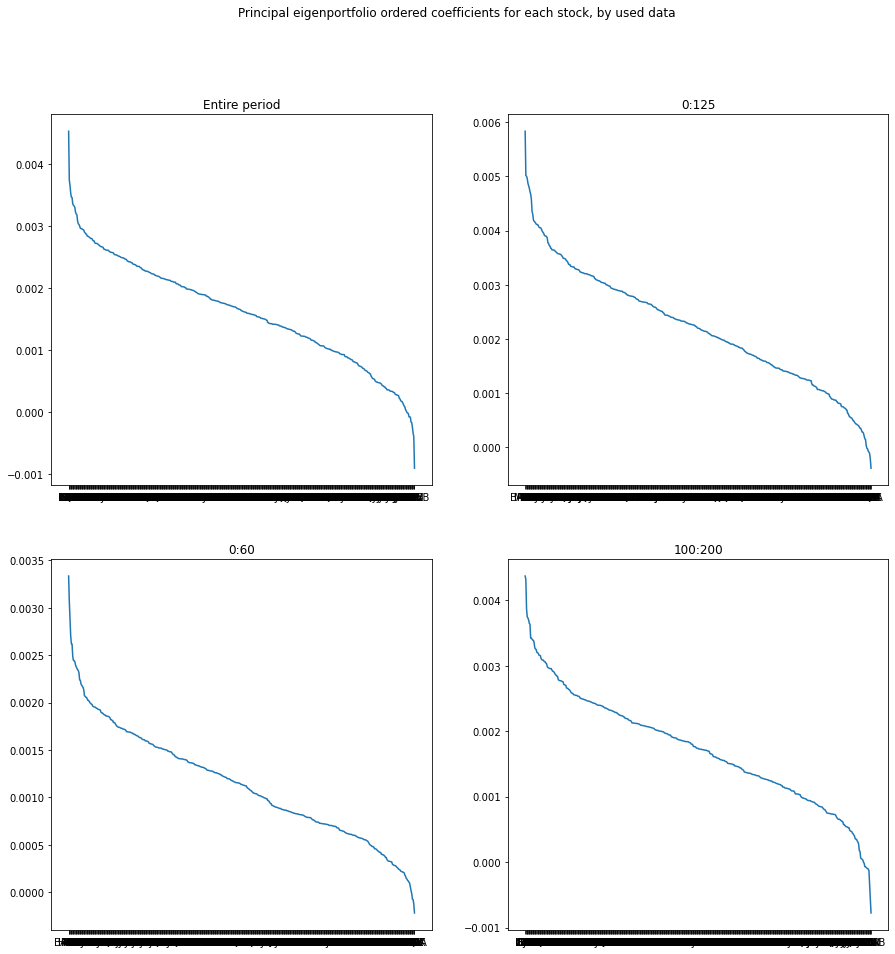

In [15]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Principal eigenportfolio ordered coefficients for each stock, by used data')
ax1.set_title("Entire period")
ax1.plot(data_0_251.sorted_stocks[0], [normalization_factor_0_251 * elt for elt in reversed(data_0_251.sorted_eigenvectors[0])])
ax2.set_title("0:125")
ax2.plot(data_0_125.sorted_stocks[0], [normalization_factor_0_125 * elt for elt in data_0_125.sorted_eigenvectors[0]])
ax3.set_title("0:60")
ax3.plot(data_0_60.sorted_stocks[0], [normalization_factor_0_60 * elt for elt in data_0_60.sorted_eigenvectors[0]])
ax4.set_title("100:200")
ax4.plot(data_100_200.sorted_stocks[0], [normalization_factor_100_200 * elt for elt in reversed(data_100_200.sorted_eigenvectors[0])])
plt.show()

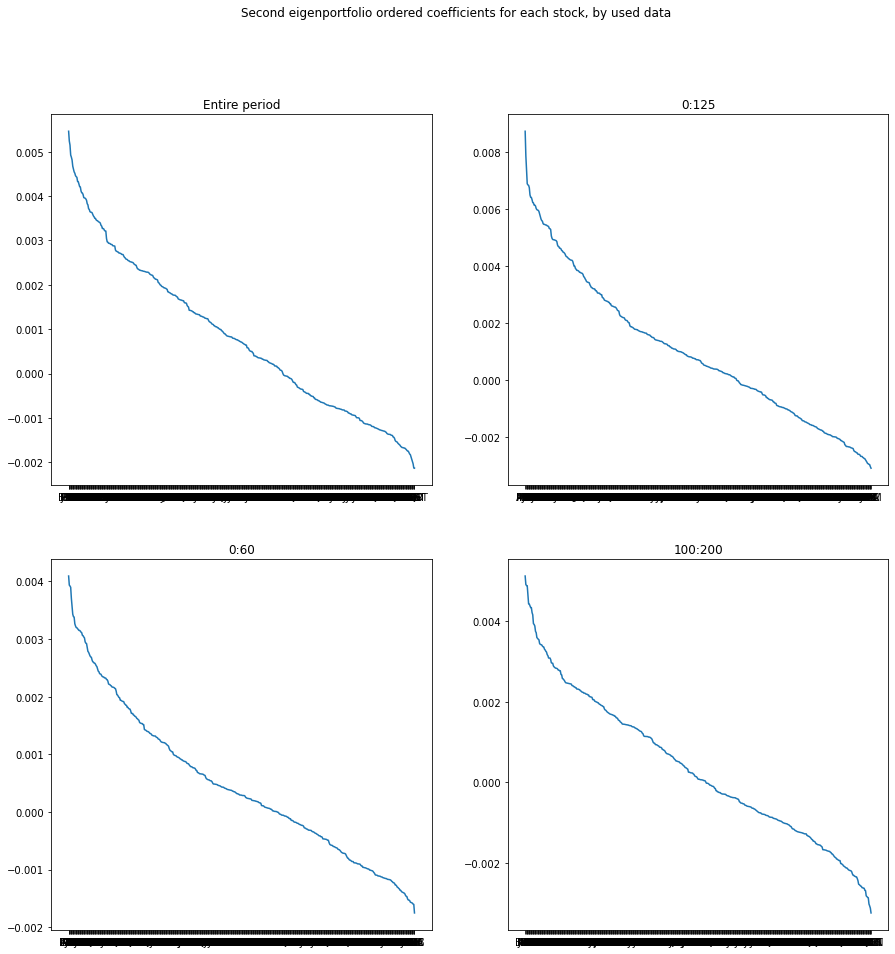

In [16]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Second eigenportfolio ordered coefficients for each stock, by used data')
ax1.set_title("Entire period")
ax1.plot(data_0_251.sorted_stocks[1], [normalization_factor_0_251 * elt for elt in reversed(data_0_251.sorted_eigenvectors[1])])
ax2.set_title("0:125")
ax2.plot(data_0_125.sorted_stocks[1], [normalization_factor_0_125 * elt for elt in data_0_125.sorted_eigenvectors[1]])
ax3.set_title("0:60")
ax3.plot(data_0_60.sorted_stocks[1], [normalization_factor_0_60 * elt for elt in data_0_60.sorted_eigenvectors[1]])
ax4.set_title("100:200")
ax4.plot(data_100_200.sorted_stocks[1], [normalization_factor_100_200 * elt for elt in reversed(data_100_200.sorted_eigenvectors[1])])
plt.show()

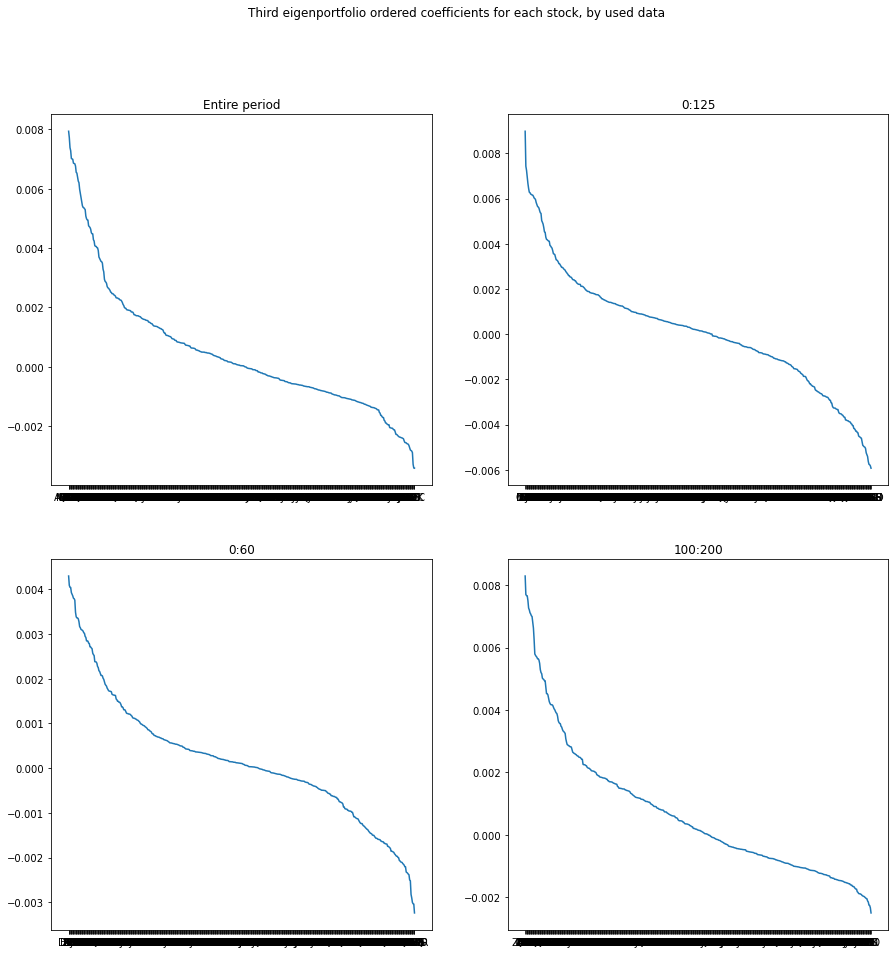

In [17]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Third eigenportfolio ordered coefficients for each stock, by used data')
ax1.set_title("Entire period")
ax1.plot(data_0_251.sorted_stocks[2], [normalization_factor_0_251 * elt for elt in reversed(data_0_251.sorted_eigenvectors[2])])
ax2.set_title("0:125")
ax2.plot(data_0_125.sorted_stocks[2], [normalization_factor_0_125 * elt for elt in data_0_125.sorted_eigenvectors[2]])
ax3.set_title("0:60")
ax3.plot(data_0_60.sorted_stocks[2], [normalization_factor_0_60 * elt for elt in data_0_60.sorted_eigenvectors[2]])
ax4.set_title("100:200")
ax4.plot(data_100_200.sorted_stocks[2], [normalization_factor_100_200 * elt for elt in reversed(data_100_200.sorted_eigenvectors[2])])
plt.show()

# Checking the industries given by the following portfolios

In [18]:
print('Cinq premiers stocks du premier eigenportfolio 0 251 : ' + str([elt for elt in reversed(data_0_251.sorted_stocks[0])][:5]), 'Cinq derniers stocks du premier eigenportfolio 0 251 : ' + str([elt for elt in reversed(data_0_251.sorted_stocks[0])][-5:]))
print('Cinq premiers stocks du premier eigenportfolio 0 125 : ' + str(data_0_125.sorted_stocks[0][:5]), 'Cinq derniers stocks du premier eigenportfolio 0 125 : ' + str(data_0_125.sorted_stocks[0][-5:]))
print('Cinq premiers stocks du premier eigenportfolio 0 60 : ' + str(data_0_60.sorted_stocks[0][:5]), 'Cinq derniers stocks du premier eigenportfolio 0 60 : ' + str(data_0_60.sorted_stocks[0][-5:]))
print('Cinq premiers stocks du premier eigenportfolio 100 200 : ' + str([elt for elt in reversed(data_100_200.sorted_stocks[0])][:5]), 'Cinq derniers stocks du premier eigenportfolio 100 200 : ' + str([elt for elt in reversed(data_100_200.sorted_stocks[0])][-5:]))

Cinq premiers stocks du premier eigenportfolio 0 251 : ['BRK-B', 'ITW', 'AME', 'HON', 'GD'] Cinq derniers stocks du premier eigenportfolio 0 251 : ['BIIB', 'CHD', 'EQIX', 'DLR', 'CLX']
Cinq premiers stocks du premier eigenportfolio 0 125 : ['BRK-B', 'MCD', 'AME', 'GD', 'VZ'] Cinq derniers stocks du premier eigenportfolio 0 125 : ['MRNA', 'TMO', 'DPZ', 'EQIX', 'CLX']
Cinq premiers stocks du premier eigenportfolio 0 60 : ['BRK-B', 'HON', 'VZ', 'AME', 'GD'] Cinq derniers stocks du premier eigenportfolio 0 60 : ['INCY', 'MRNA', 'EA', 'EQIX', 'CLX']
Cinq premiers stocks du premier eigenportfolio 100 200 : ['BRK-B', 'ITW', 'HON', 'EMR', 'AFL'] Cinq derniers stocks du premier eigenportfolio 100 200 : ['HRL', 'DLR', 'SJM', 'CPB', 'CLX']


#### Table listing the 5 first stocks with the most important value in the first eigenportfolio

  | | 0 251  | 0 125    | 0 60   | 100 200   |
|---:|:-------------|:-------------|:-------------|:-------------|
| 1 | Berkshire Hathaway Inc.  | Berkshire Hathaway Inc. | Berkshire Hathaway Inc. | Berkshire Hathaway Inc. |
| 2 | Illinois Tool Work Inc.  | McDonald's Corporation    |  Honeywell International Inc.   | Illinois Tool Works Inc. |
| 3 | AMETEK, Inc.  | AMETEK, Inc.  | Verizon Communication   | Honeywell International Inc. |
| 4 | Honeywell International Inc.  | General Dynamics Corporation    | AMETEK, Inc. | Emerson Electric Co. |
| 5 | General Dynamics Corporation  | Verizon Communication | General Dynamics Corporation | Aflac Incorporated |

#### Table listing the 5 last stocks with the less important value in the first eigenportfolio

  | | 0 251  | 0 125    | 0 60   | 100 200   |
|---:|:-------------|:-------------|:-------------|:-------------|
| 1 | Biogen Inc. | Moderna, Inc. | Incyte Corporation | Hormel Foods Corporation |
| 2 | Church & Dwight Co., Inc. | Thermo Fisher Scientific Inc. | Moderna, Inc. | Digital Realty Trust, Inc. |
| 3 | Equinix, Inc. | Domino's Pizza, Inc. | Electronic Arts Inc. | The J. M. Smucker Company |
| 4 | Digital Realty Trust, Inc. | Equinix, Inc. | Equinix, Inc. | Campbell Soup Company |
| 5 | The Clorox Company | The Clorox Company | The Clorox Company | The Clorox Company |

In [19]:
print('Cinq premiers stocks du deuxième eigenportfolio 0 251 : ' + str([elt for elt in reversed(data_0_251.sorted_stocks[1])][:5]), 'Cinq derniers stocks du deuxième eigenportfolio 0 251 : ' + str([elt for elt in reversed(data_0_251.sorted_stocks[1])][-5:]))
print('Cinq premiers stocks du deuxième eigenportfolio 0 125 : ' + str(data_0_125.sorted_stocks[1][:5]), 'Cinq derniers stocks du deuxième eigenportfolio 0 125 : ' + str(data_0_125.sorted_stocks[1][-5:]))
print('Cinq premiers stocks du deuxième eigenportfolio 0 60 : ' + str(data_0_60.sorted_stocks[1][:5]), 'Cinq derniers stocks du deuxième eigenportfolio 0 60 : ' + str(data_0_60.sorted_stocks[1][-5:]))
print('Cinq premiers stocks du deuxième eigenportfolio 100 200 : ' + str([elt for elt in reversed(data_100_200.sorted_stocks[1])][:5]), 'Cinq derniers stocks du deuxième eigenportfolio 100 200 : ' + str([elt for elt in reversed(data_100_200.sorted_stocks[1])][-5:]))

Cinq premiers stocks du deuxième eigenportfolio 0 251 : ['COST', 'PG', 'PEP', 'MSFT', 'MCO'] Cinq derniers stocks du deuxième eigenportfolio 0 251 : ['PNC', 'USB', 'PRU', 'JPM', 'BAC']
Cinq premiers stocks du deuxième eigenportfolio 0 125 : ['PEP', 'PG', 'AMT', 'MKC', 'JNJ'] Cinq derniers stocks du deuxième eigenportfolio 0 125 : ['JPM', 'CMA', 'BAC', 'C', 'XOM']
Cinq premiers stocks du deuxième eigenportfolio 0 60 : ['PEP', 'PG', 'ABT', 'JNJ', 'DGX'] Cinq derniers stocks du deuxième eigenportfolio 0 60 : ['XOM', 'KEY', 'CMA', 'PNC', 'USB']
Cinq premiers stocks du deuxième eigenportfolio 100 200 : ['VRSN', 'PLD', 'CCI', 'MSFT', 'ADBE'] Cinq derniers stocks du deuxième eigenportfolio 100 200 : ['BK', 'PRU', 'AFL', 'JPM', 'BAC']


#### Table listing the 5 first stocks with the most important value in the second eigenportfolio

  | | 0 251  | 0 125    | 0 60   | 100 200   |
|---:|:-------------|:-------------|:-------------|:-------------|
| 1 | Costco Wholesale Corporation | PepsiCo, Inc. | PepsiCo, Inc. | VeriSign, Inc. |
| 2 | The Procter & Gamble Company | The Procter & Gamble Company |  The Procter & Gamble Company | Prologis, Inc. |
| 3 | PepsiCo, Inc. | American Tower Corporation | Abbott Laboratories | Crown Castle International Corp. |
| 4 | Microsoft Corporation | McCormick & Company, Incorporated | Johnson & Johnson | Microsoft Corporation |
| 5 | Moody's Corporation | Johnson & Johnson | Quest Diagnostics Incorporated | Adobe Inc. |

#### Table listing the 5 last stocks with the less important value in the second eigenportfolio

  | | 0 251  | 0 125    | 0 60   | 100 200   |
|---:|:-------------|:-------------|:-------------|:-------------|
| 1 | The PNC Financial Services Group, Inc. | JPMorgan Chase & Co. | Exxon Mobil Corporation | The Bank of New York Mellon Corporation |
| 2 | U.S. Bancorp | Comerica Incorporated | KeyCorp | Prudential Financial, Inc. |
| 3 | Prudential Financial, Inc. | Bank of America Corporation | Comerica Incorporated | Aflac Incorporated |
| 4 | JPMorgan Chase & Co. | Citigroup Inc. | The PNC Financial Services Group, Inc. | JPMorgan Chase & Co. |
| 5 | Bank of America Corporation | Exxon Mobil Corporation | U.S. Bancorp | Bank of America Corporation |

In [20]:
print('Cinq premiers stocks du troisième eigenportfolio 0 251 : ' + str([elt for elt in reversed(data_0_251.sorted_stocks[2])][:5]), 'Cinq derniers stocks du troisième eigenportfolio 0 251 : ' + str([elt for elt in reversed(data_0_251.sorted_stocks[2])][-5:]))
print('Cinq premiers stocks du troisième eigenportfolio 0 125 : ' + str(data_0_125.sorted_stocks[2][:5]), 'Cinq derniers stocks du troisième eigenportfolio 0 125 : ' + str(data_0_125.sorted_stocks[2][-5:]))
print('Cinq premiers stocks du troisième eigenportfolio 0 60 : ' + str(data_0_60.sorted_stocks[2][:5]), 'Cinq derniers stocks du troisième eigenportfolio 0 60 : ' + str(data_0_60.sorted_stocks[2][-5:]))
print('Cinq premiers stocks du troisième eigenportfolio 100 200 : ' + str([elt for elt in reversed(data_100_200.sorted_stocks[2])][:5]), 'Cinq derniers stocks du troisième eigenportfolio 100 200 : ' + str([elt for elt in reversed(data_100_200.sorted_stocks[2])][-5:]))

Cinq premiers stocks du troisième eigenportfolio 0 251 : ['ED', 'WEC', 'DUK', 'D', 'AEE'] Cinq derniers stocks du troisième eigenportfolio 0 251 : ['INTU', 'MCHP', 'TXN', 'ADI', 'AVGO']
Cinq premiers stocks du troisième eigenportfolio 0 125 : ['VZ', 'ED', 'CHD', 'DUK', 'SJM'] Cinq derniers stocks du troisième eigenportfolio 0 125 : ['ADBE', 'KEYS', 'ANSS', 'AVGO', 'INTU']
Cinq premiers stocks du troisième eigenportfolio 0 60 : ['NI', 'DUK', 'SO', 'K', 'ED'] Cinq derniers stocks du troisième eigenportfolio 0 60 : ['ANSS', 'MPWR', 'KEYS', 'TXN', 'AVGO']
Cinq premiers stocks du troisième eigenportfolio 100 200 : ['ED', 'D', 'CHD', 'CL', 'DUK'] Cinq derniers stocks du troisième eigenportfolio 100 200 : ['IPGP', 'CTLT', 'TEL', 'ADI', 'ZBRA']


#### Table listing the 5 first stocks with the most important value in the third eigenportfolio

  | | 0 251  | 0 125    | 0 60   | 100 200   |
|---:|:-------------|:-------------|:-------------|:-------------|
| 1 | Consolidated Edison, Inc. | Verizon Communications Inc. | NiSource Inc. | Consolidated Edison, Inc. |
| 2 | WEC Energy Group, Inc. | Consolidated Edison, Inc. | Duke Energy Corporation | Dominion Energy, Inc. |
| 3 | Duke Energy Corporation | Church & Dwight Co., Inc. | The Southern Company | Church & Dwight Co., Inc. |
| 4 | Dominion Energy, Inc. | Duke Energy Corporation | Kellogg Company | Colgate-Palmolive Company |
| 5 | Ameren Corporation | The J. M. Smucker Company | Consolidated Edison, Inc. | Duke Energy Corporation |

#### Table listing the 5 last stocks with the less important value in the second eigenportfolio

  | | 0 251  | 0 125    | 0 60   | 100 200   |
|---:|:-------------|:-------------|:-------------|:-------------|
| 1 | Intuit Inc. | Adobe Inc. | ANSYS, Inc. | IPG Photonics Corporation |
| 2 | Microchip Technology Incorporated | Keysight Technologies, Inc. | Monolithic Power Systems, Inc. | Catalent, Inc. |
| 3 | Texas Instruments Incorporated | ANSYS, Inc. | Keysight Technologies, Inc. | TE Connectivity Ltd. |
| 4 | Analog Devices, Inc. | Broadcom Inc. | Texas Instruments Incorporated | Analog Devices, Inc. |
| 5 | Broadcom Inc. | Intuit Inc. | Broadcom Inc. | Zebra Technologies Corporation |

# Implement the trading strategy

In [64]:
data_0_251.process_trading_strategy(sliding_days=60, reference_data=SP500_cumulated_returns)
data_0_125.process_trading_strategy(sliding_days=60, reference_data=SP500_cumulated_returns)
data_0_60.process_trading_strategy(sliding_days=60, reference_data=SP500_cumulated_returns)
data_100_200.process_trading_strategy(sliding_days=60, reference_data=SP500_cumulated_returns)

C:\Users\Upriz\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
C:\Users\Upriz\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
C:\Users\Upriz\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


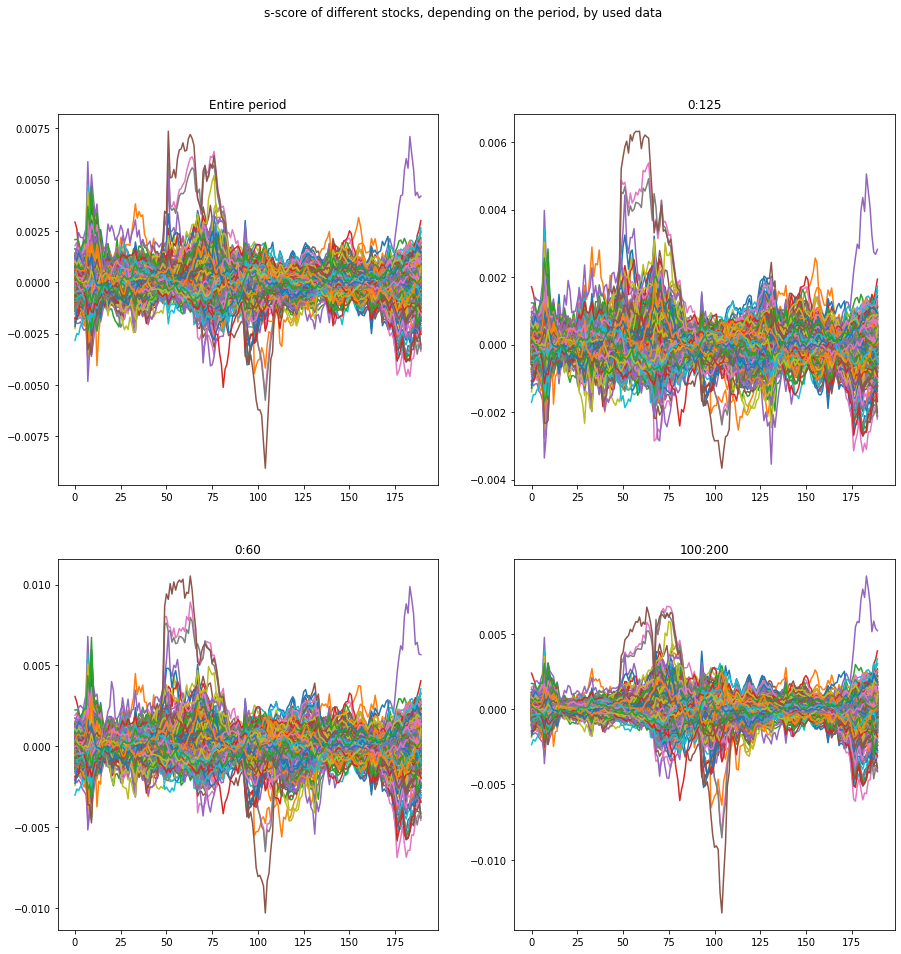

In [22]:
x = [i for i in range(190)]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('s-score of different stocks, depending on the period, by used data')
ax1.set_title("Entire period")
for stock_name, s_score in data_0_251.s_scores.items():
    ax1.plot(x, s_score)
ax2.set_title("0:125")
for stock_name, s_score in data_0_125.s_scores.items():
    ax2.plot(x, s_score)
ax3.set_title("0:60")
for stock_name, s_score in data_0_60.s_scores.items():
    ax3.plot(x, s_score)
ax4.set_title("100:200")
for stock_name, s_score in data_100_200.s_scores.items():
    ax4.plot(x, s_score)
plt.show()

Plotting the s-scores of the different selected stocks. We remark that none of them excess $1.25$ or is below $-1.25$, which are the values used by the paper to implement the trading strategy.

In [65]:
data_0_125.compute_PNL(0.2)
data_0_60.compute_PNL(0.2)
data_100_200.compute_PNL(0.2)

In [66]:
ending_portfolio_value_0_125 = 0
ending_portfolio_value_0_60 = 0
ending_portfolio_value_100_200 = 0

for stock_name, portfolio_value in data_0_125.detailed_portfolios[-1].items():
    ending_portfolio_value_0_125 += portfolio_value * data_0_125.data[stock_name][-1]

for stock_name, portfolio_value in data_0_60.detailed_portfolios[-1].items():
    ending_portfolio_value_0_60 += portfolio_value * data_0_60.data[stock_name][-1]
    
for stock_name, portfolio_value in data_100_200.detailed_portfolios[-1].items():
    ending_portfolio_value_100_200 += portfolio_value * data_100_200.data[stock_name][-1]

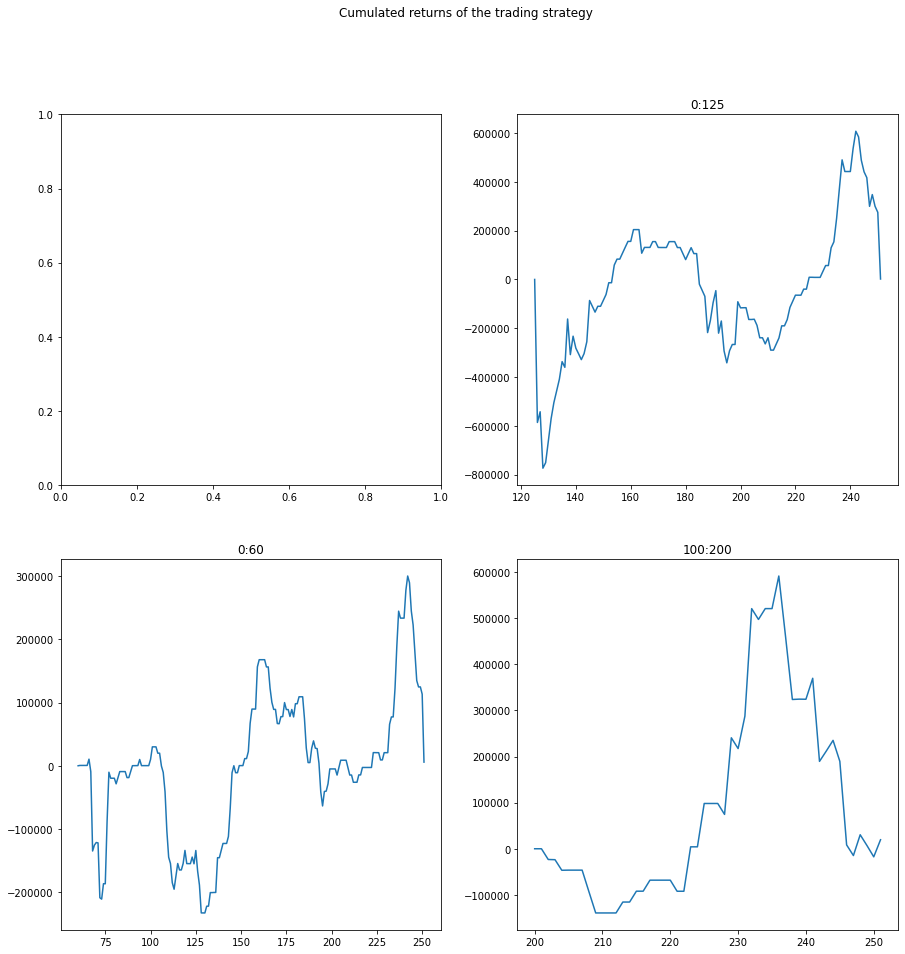

In [67]:
data_0_125.cumulated_PNL.append(data_0_125.cumulated_PNL[-1] + ending_portfolio_value_0_125)
data_0_60.cumulated_PNL.append(data_0_60.cumulated_PNL[-1] + ending_portfolio_value_0_60)
data_100_200.cumulated_PNL.append(data_100_200.cumulated_PNL[-1] + ending_portfolio_value_100_200)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Cumulated returns of the trading strategy')
ax2.set_title("0:125")
ax2.plot([i for i in range(data_0_125.end, data_0_125.data_length + 1)], data_0_125.cumulated_PNL[data_0_125.end:data_0_125.data_length + 1])
ax3.set_title("0:60")
ax3.plot([i for i in range(data_0_60.end, data_0_60.data_length + 1)], data_0_60.cumulated_PNL[data_0_60.end:data_0_60.data_length + 1])
ax4.set_title("100:200")
ax4.plot([i for i in range(data_100_200.end, data_100_200.data_length + 1)], data_100_200.cumulated_PNL[data_100_200.end:data_100_200.data_length + 1])
plt.show()

In [68]:
print(data_0_125.cumulated_PNL[-1], data_0_60.cumulated_PNL[-1], data_100_200.cumulated_PNL[-1])

1822.323615503963 5727.364081731401 19531.919448560428
